In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import MiniBatchSparsePCA, PCA, TruncatedSVD, FastICA, MiniBatchDictionaryLearning
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, make_scorer, precision_score, hamming_loss
from multiprocessing import pool
from scipy import sparse
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

%matplotlib inline

ImportError: No module named 'spacy'

In [ ]:
events = pd.read_csv('../data/NOTEEVENTS.csv')
diagnoses_icd = pd.read_csv('../data/DIAGNOSES_ICD.csv')
diagnoses = pd.read_csv('../data/D_ICD_DIAGNOSES.csv')

In [3]:
print('Patient Count:', events.SUBJECT_ID.unique().shape[0])
print('Admission Count:', events.HADM_ID.unique().shape[0])
print('Diagnosis Count:', diagnoses_icd.shape[0])
print('Unique Diagnoses:', diagnoses_icd.ICD9_CODE.unique().shape[0])
events.groupby(['SUBJECT_ID']).HADM_ID.apply(lambda x: x.dropna().unique().shape[0]).mean()

Patient Count: 46146
Admission Count: 58362
Diagnosis Count: 651047
Unique Diagnoses: 6985


1.2647033328999264

# Diagnoses Info

In [5]:
diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [6]:
diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


# Keep Only Top N Occurring Diagnoses

In the research paper, they evaluate based on top 50 and top 100 occurring diagnoses. We can see for the top 100 diagnoses, this leaves us with 56K unique hospital admissions.

56437

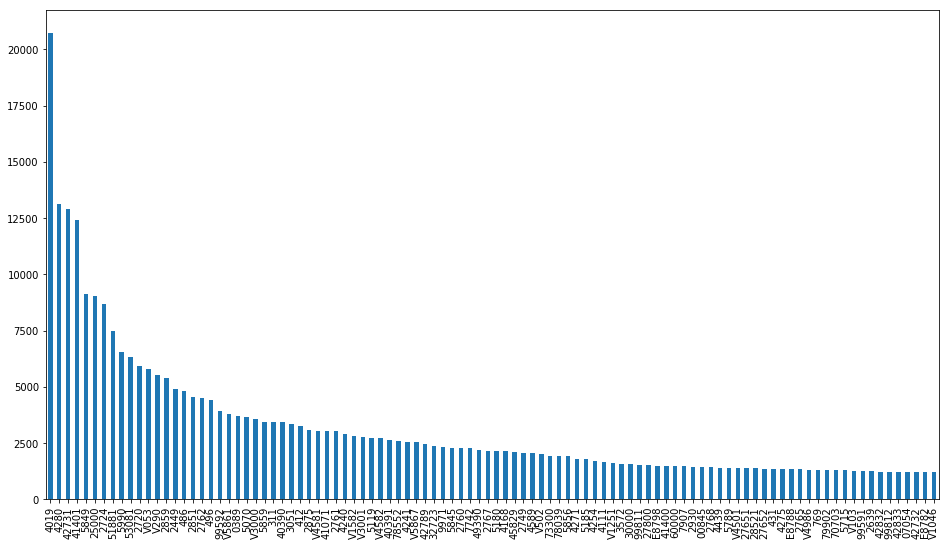

In [7]:
diag_counts = diagnoses_icd.ICD9_CODE.value_counts()
diag_counts = diag_counts[diag_counts > 1]
keep_codes = diag_counts[:100].index

keep_diag = diagnoses_icd[diagnoses_icd.ICD9_CODE.isin(keep_codes)]
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
diag_counts[:100].plot(kind='bar', ax=ax)

len(keep_diag.HADM_ID.unique())

# Note Events

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


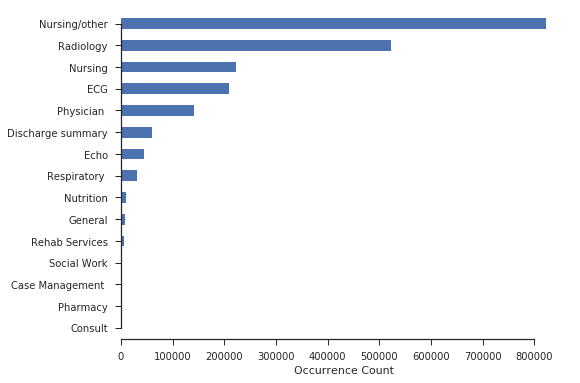

In [101]:
ax = events.CATEGORY.value_counts()[::-1].plot(kind='barh', figsize=(8, 6))
ax.set_xlabel('Occurrence Count')
sns.despine(trim=True)
events.head()

# Remove Events We Don't Want
Remove events that contain any form of `diagnosis`. Probably better to use a regex, but I'm not great at regexs, and this was fast.

In [9]:
event_keep_cols = ['HADM_ID', 'TEXT']
events_keep = events[event_keep_cols].dropna()

banned_terms = ['DIAGNOSE', 'diagnose', 'Diagnose', 'diagnosis', 'Diagnosis',
               'DIAGNOSIS']
for term in banned_terms:
    events_keep = events_keep[np.logical_not(events_keep.TEXT.str.contains(term))]

In [10]:
events.shape, events_keep.shape

((2083180, 11), (1436936, 2))

# Make Feature Rows
Make feature rows based on hospital admission ID.

This concatenates all of the text from each hospital stay.

In [11]:
hadm_text = events_keep.groupby('HADM_ID').TEXT.sum()

hadm_df = pd.DataFrame(hadm_text)
hadm_df.head()

,TEXT
HADM_ID,
100001.0,[**2117-9-11**] 11:12 AM\n CHEST (PA & LAT) ...
100003.0,PATIENT/TEST INFORMATION:\nIndication: Left ve...
100006.0,PATIENT/TEST INFORMATION:\nIndication: Left ve...
100007.0,Sinus rhythm\nAtrial premature complex\nConsid...
100009.0,PATIENT/TEST INFORMATION:\nIndication: Abnorma...


# Join With Diagnosis Info
Now we have a blob of text associated with a hospital stay. This means we can now pair all diagnoses for each hospital stay with all associated text from the same stay.

In [14]:
diag_text_df = keep_diag.join(hadm_df, on='HADM_ID').dropna()
diag_text_last = diag_text_df.groupby('HADM_ID').TEXT.last()

label_df = pd.DataFrame(list(diag_text_df.groupby('HADM_ID').ICD9_CODE), 
                        columns=['HADM_ID', 'ICD9_CODE']).set_index('HADM_ID')
label_df['ICD9_CODE'] = label_df.ICD9_CODE.apply(list)

final_df = label_df.join(diag_text_last)#.sample(n=50000)

final_df.head()

,ICD9_CODE,TEXT
HADM_ID,,
100001,"[5849, V5867, 40390]",[**2117-9-11**] 11:12 AM\n CHEST (PA & LAT) ...
100003,"[2851, 07054, 5715, 4019]",PATIENT/TEST INFORMATION:\nIndication: Left ve...
100006,"[51881, 486, 2761, V1251, V1582]",PATIENT/TEST INFORMATION:\nIndication: Left ve...
100007,"[486, 4019]",Sinus rhythm\nAtrial premature complex\nConsid...
100009,"[41401, 25000, 27800, 4111, V4582, V1582, 2859...",PATIENT/TEST INFORMATION:\nIndication: Abnorma...


# TF-IDF Via Hashing
https://spark.apache.org/docs/1.2.0/mllib-feature-extraction.html

* First, hash in parallel because we can (I'm sure Spark will do this automagically)
* Next, collect all of the hash matrices and stack them all up.
* Finally, calculate TF-IDF transform.

Note that we end up with a final feature matrix of shape `(50000, 250000)`

In [22]:
def vectorize(x):
        
    def clean_string(to_clean):
        to_clean = to_clean.replace('\n', ' ')
        subbed = ''.join([i for i in to_clean 
                          if i.isalpha() or i == ' ' or i == '/']) 
        
        return subbed.lower()
    
    # clean all strings and convert to lower case
    x = map(clean_string, x)
    
    return text.HashingVectorizer(ngram_range=(1, 1),
                                  n_features=250000,
                                  stop_words='english',
                                  norm=None,
                                  non_negative=True
                                  ).fit_transform(x)
    
my_pool = pool.Pool(processes=32)
results = my_pool.map_async(vectorize, np.array_split(final_df.TEXT.values, 1000))
%time all_mat = results.get()
my_pool.close()

CPU times: user 1.81 s, sys: 4.54 s, total: 6.34 s
Wall time: 34.4 s


In [91]:
print("Patient Count for final dataset:", keep_diag.SUBJECT_ID.unique().shape[0])
print("Admission Count for final dataset:", keep_diag.HADM_ID.unique().shape[0])
print("Diagnosis Count for final dataset:", keep_diag.shape[0])
print("Unique Diagnoses Count for final dataset:", keep_diag.ICD9_CODE.unique().shape[0])

Patient Count for final dataset: 44591
Admission Count for final dataset: 56437
Diagnosis Count for final dataset: 318825
Unique Diagnoses Count for final dataset: 100


Total Tokens in Corpus: 177723715.0
Total Unique Tokens in Corpus: 229130
Median Tokens per HADM_ID: 929.0


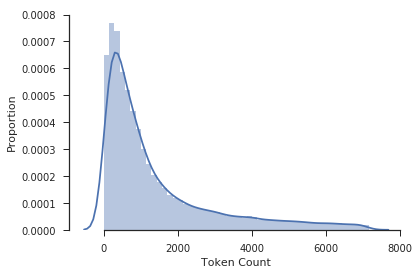

In [84]:
stacked_mat = sparse.vstack(all_mat)
counts = np.array(stacked_mat.sum(axis=1))[:, 0]

cutoff = np.percentile(counts, 90)

fig = plt.figure()
ax = fig.add_subplot(111)
sns.distplot(pd.Series(counts[counts < cutoff]), ax=ax, norm_hist=False)
sns.despine(trim=True, ax=ax)
ax.set_xlabel('Token Count')
ax.set_ylabel('Proportion')

print('Total Tokens in Corpus:', counts.sum())
print('Total Unique Tokens in Corpus:', stacked_mat[:,stacked_mat.getnnz(0)>0].shape[1])
print('Median Tokens per HADM_ID:', np.median(counts))

Median Diagnosis Count: 5.0


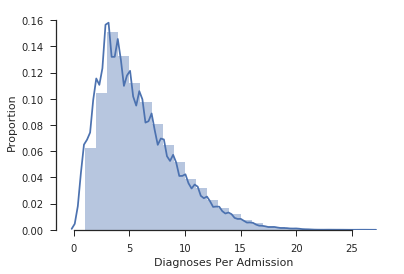

In [81]:
diag_counts = final_df.ICD9_CODE.apply(len)

fig = plt.figure()
ax = fig.add_subplot(111)
sns.distplot(diag_counts, ax=ax, norm_hist=False, bins=25)
sns.despine(trim=True, ax=ax)
ax.set_xlabel('Diagnoses Per Admission')
ax.set_ylabel('Proportion')

print('Median Diagnosis Count:', np.median(diag_counts))

Median Notes Per HADM_ID: 10.0


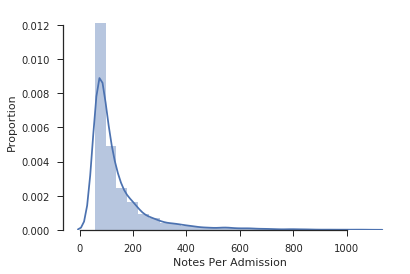

In [82]:
note_count = events_keep.groupby('HADM_ID').count().TEXT
note_cutoff = np.percentile(note_count, 90)

fig = plt.figure()
ax = fig.add_subplot(111)
sns.distplot(note_count[note_count > note_cutoff], ax=ax, norm_hist=False, bins=25)
sns.despine(trim=True, ax=ax)
ax.set_xlabel('Notes Per Admission')
ax.set_ylabel('Proportion')

print('Median Notes Per HADM_ID:', np.median(note_count))